<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/modelbat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 23

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL
import plotly
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D, Activation)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils

## เตรียมชุดของข้อมูล

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/lastoct'  # data เราอยู่โฟล์เดอร์ไหน

In [5]:
image = cv2.imread('/content/drive/My Drive/lastoct/train/CSC/IA3870 19-12-16 RE_000_cropped.png')

In [6]:
batch_size = 32   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [7]:
# Train
train_dir = "/content/drive/My Drive/lastoct/train"
train_datagen = ImageDataGenerator(rescale = 1./255,
         rotation_range = 50,
         zoom_range = 0.5)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 17779 images belonging to 4 classes.


In [8]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[4552 4469 4385 4373]


In [9]:
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

for i in ids:
  print('{:>6} = {}' .format(labels[i], counts[i]))

   CSC = 4552
Normal = 4469
   PCV = 4385
   VKH = 4373


In [10]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [11]:
# Validation
val_dir ="/content/drive/My Drive/lastoct/validation"
val_datagen = ImageDataGenerator(rescale = 1./255,         
       rotation_range = 50,
       zoom_range = 0.5)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 2217 images belonging to 4 classes.


In [12]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[528 546 540 603]


## Test

In [13]:
# Test
test_dir ="/content/drive/My Drive/lastoct/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 2182 files belonging to 4 classes.


In [14]:
class_names = test_set.class_names
print(class_names)

['CSC', 'Normal', 'PCV', 'VKH']


##### ดูตัวอย่างคลาส และแสดงภาพ

{'CSC': 0, 'Normal': 1, 'PCV': 2, 'VKH': 3}
(32, 256, 256, 3)
(32, 4)
class: [0. 0. 0. 1.]


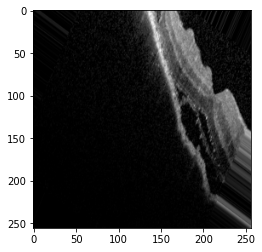

In [15]:
# เป็นการสุ่มดูภาพใน train_set
print(train_set.class_indices)
for image_batch, labels_batch in  train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  plt.imshow(image_batch[0])
  print('class:', labels_batch[0])  # ภาพอยู่ในคลาสใด
  break

### Visualize ดูภาพ

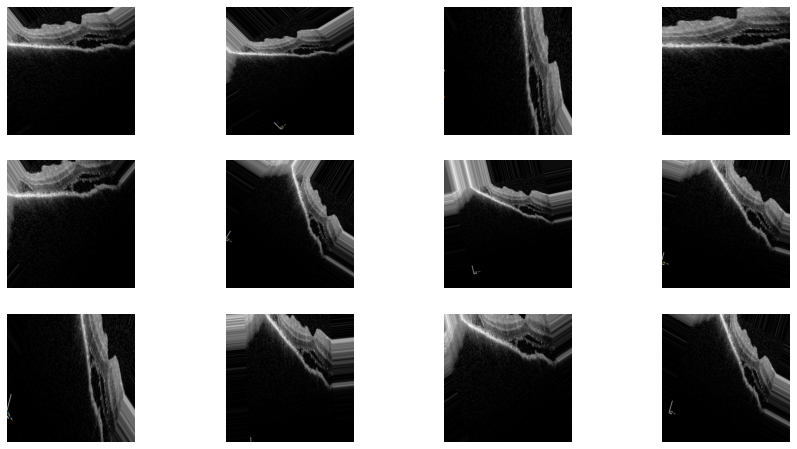

In [16]:
# ดูหลายภาพ
nplots = 12

def visual_multi(images_arr):
  fig = plt.figure(figsize = (15, 8))
  for j in range(nplots):
    plt.subplot(3, 4, j+1)
    plt.imshow(images_arr[j])
    plt.axis('off')
  plt.show()

augmented_images = [train_set[0][0][0] for i in range(nplots)]
visual_multi(augmented_images)

## Training 

### สร้าง Model

In [17]:
num_classes = 4
epochs=10   # จำนวนครั้งที่เราจะ Train
# ขนาดภาพอินพุตเข้าสู่ Model
in_shape = (256,256,3)
in_shape

(256, 256, 3)

In [18]:
model = Sequential()
#1. CNN LAYER
model.add(Conv2D(filters = 16, kernel_size = (3,3),input_shape=(in_shape)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2. CNN LAYER
model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

#3. CNN LAYER
model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#FULLY CONNECTED LAYER
model.add(Flatten())
model.add(Dense(4))
model.add(BatchNormalization())
model.add(Activation("relu"))

#OUTPUT LAYER
model.add(Dense(4, activation='softmax'))
model.summary()          # ดูสรุปโครงสร้าง Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 254, 254, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 252, 252, 32)      0

##### ดู kernel

In [19]:
for layer in model.layers:
  if 'conv' not in layer.name:
       continue
  kernels, biases = layer.get_weights()
  print(layer.name, 'shape:', kernels.shape)

conv2d shape: (3, 3, 3, 16)
conv2d_1 shape: (3, 3, 16, 32)
conv2d_2 shape: (3, 3, 32, 64)


In [20]:
k_min, k_max = kernels.min(), kernels.max()
kernels = (kernels - k_min)/ (k_max - k_min)
kernel_idx = 0
kernel_i = kernels[:, :, 0, kernel_idx]
print(kernel_i.round(2))

[[0.87 0.5  0.22]
 [0.88 0.3  0.38]
 [0.69 0.97 0.64]]


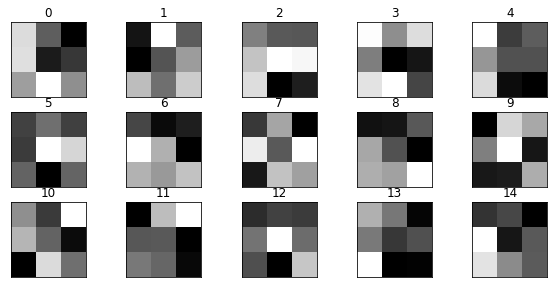

In [21]:
nplots = 15
fig = plt.figure(figsize = (10, 8))
for j in range(nplots):
  plt.subplot(5, 5, j+1)
  plt.imshow(kernels[:, :, 0, j], cmap = plt.cm.gray)
  plt.title(j)
  plt.xticks([]); plt.yticks([])
plt.show()

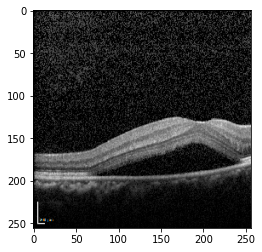

In [22]:
image = load_img('/content/drive/My Drive/lastoct/train/CSC/IA3870 19-12-16 RE_000_cropped.png', target_size=(256, 256))
plt.imshow(image)
plt.show()

In [23]:
img1 = img_to_array(image)
print('shape =', img1.shape)
print('max pixel value =', np.max(img1))

shape = (256, 256, 3)
max pixel value = 255.0


### Compile และ Train

In [24]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
start = time.time()

history = model.fit(train_set, steps_per_epoch=len(train_set),
                    validation_data=val_set, 
                    epochs=10,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/10
556/556 [==============================] - 3631s 7s/step - loss: 1.3444 - accuracy: 0.3486 - val_loss: 1.5904 - val_accuracy: 0.3117
Epoch 2/10
556/556 [==============================] - 707s 1s/step - loss: 1.2156 - accuracy: 0.4648 - val_loss: 1.3411 - val_accuracy: 0.3897
Epoch 3/10
556/556 [==============================] - 718s 1s/step - loss: 1.0835 - accuracy: 0.5382 - val_loss: 1.1834 - val_accuracy: 0.4700
Epoch 4/10
556/556 [==============================] - 718s 1s/step - loss: 0.9930 - accuracy: 0.5800 - val_loss: 1.0727 - val_accuracy: 0.5124
Epoch 5/10
556/556 [==============================] - 720s 1s/step - loss: 0.9145 - accuracy: 0.6216 - val_loss: 1.1316 - val_accuracy: 0.5485
Epoch 6/10
556/556 [==============================] - 722s 1s/step - loss: 0.8712 - accuracy: 0.6437 - val_loss: 1.0836 - val_accuracy: 0.5255
Epoch 7/10
556/556 [==============================] - 719s 1s/step - loss: 0.8403 - accuracy: 0.6606 - val_loss: 1.2739 - val_accuracy: 0.470

### Save Model

In [26]:
with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='modelOCT1.h5'
model.save(filepath)
filepath_model = 'modelOCT1.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")

Saved model to disk


### Load Model

In [27]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 254, 254, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 252, 252, 32)      0

## ประเมิน

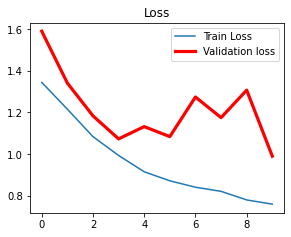

In [28]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

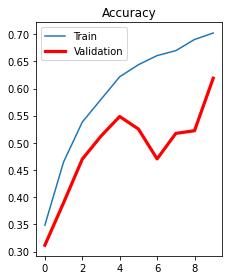

In [29]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.618


### Prediction

In [31]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image

1/1 [==============================] - 0s 411ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536692, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


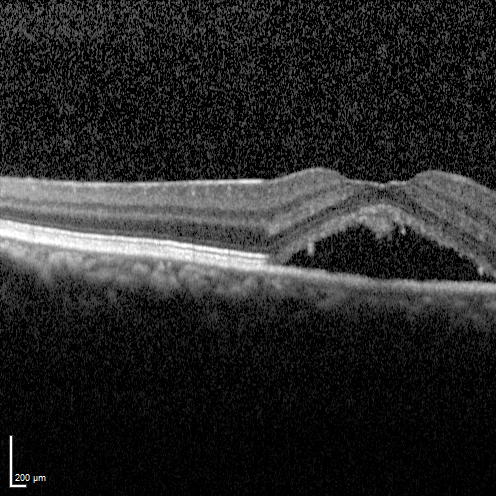

AI Normal มีความมั่นใจ 47.54%.


In [32]:
# CSC
test_path = ('/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 31ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536692, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


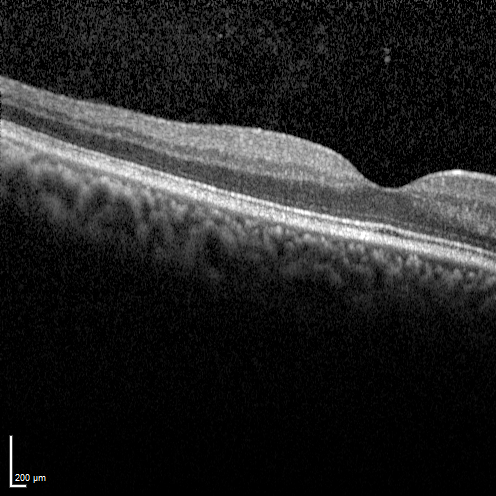

AI Normal มีความมั่นใจ 47.54%.


In [33]:
# Normal
test_path = ('/content/drive/My Drive/lastoct/test/Normal/CJ5901 24-01-19 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 30ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536692, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


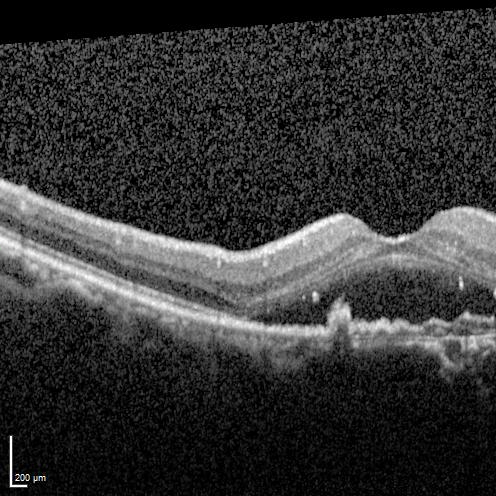

AI Normal มีความมั่นใจ 47.54%.


In [34]:
# PCV
test_path = ('/content/drive/My Drive/lastoct/test/PCV/AV0940 20-09-16 RE_001003_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 29ms/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) Normal tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.1748777, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


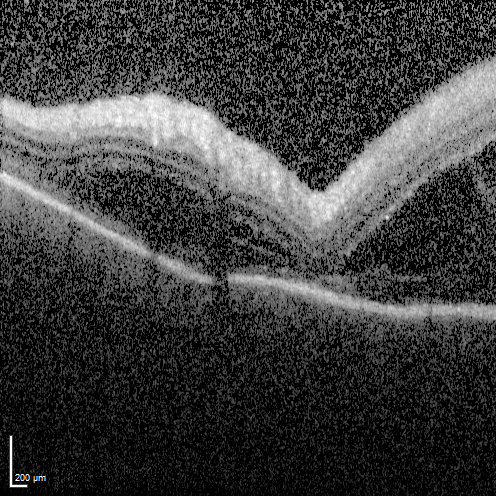

AI VKH มีความมั่นใจ 47.54%.


In [35]:
# VKH
test_path = ('/content/drive/My Drive/lastoct/test/VKH/KH7322 18-12-20 LE_001004_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [36]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "Normal"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 29ms/step


In [37]:
print(y_test)
print(len(y_test))
print(y_pred)
print(len(y_pred))

['CSC', 'VKH', 'CSC', 'Normal', 'CSC', 'PCV', 'PCV', 'PCV', 'Normal', 'Normal', 'Normal', 'PCV', 'CSC', 'VKH', 'Normal', 'VKH', 'Normal', 'PCV', 'Normal', 'CSC', 'CSC', 'CSC', 'PCV', 'PCV', 'VKH', 'Normal', 'VKH', 'Normal', 'PCV', 'CSC', 'PCV', 'Normal', 'Normal', 'CSC', 'CSC', 'VKH', 'Normal', 'VKH', 'CSC', 'VKH', 'Normal', 'PCV', 'VKH', 'CSC', 'VKH', 'CSC', 'PCV', 'CSC', 'VKH', 'CSC', 'PCV', 'Normal', 'Normal', 'PCV', 'PCV', 'CSC', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'CSC', 'VKH', 'VKH', 'VKH', 'PCV', 'VKH', 'PCV', 'VKH', 'PCV', 'Normal', 'VKH', 'Normal', 'VKH', 'PCV', 'CSC', 'PCV', 'PCV', 'Normal', 'CSC', 'VKH', 'PCV', 'PCV', 'PCV', 'CSC', 'Normal', 'Normal', 'PCV', 'Normal', 'VKH', 'VKH', 'CSC', 'PCV', 'PCV', 'Normal', 'CSC', 'VKH', 'Normal', 'PCV', 'CSC', 'PCV', 'CSC', 'CSC', 'Normal', 'PCV', 'VKH', 'PCV', 'CSC', 'PCV', 'CSC', 'PCV', 'CSC', 'Normal', 'VKH', 'CSC', 'VKH', 'Normal', 'PCV', 'VKH', 'PCV', 'VKH', 'Normal', 'VKH', 'VKH', 'VKH', 'Normal', 'PCV', 'VKH', 'Nor

## Confusion Matrix

In [38]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
confusion_matrix(y_test, y_pred)

array([[  0, 528,   0,  24],
       [  0, 564,   0,   6],
       [  0, 523,   0,   5],
       [  0, 388,   0, 144]])

In [40]:
cm = confusion_matrix(y_test, y_pred)

In [41]:
test_set.class_names

['CSC', 'Normal', 'PCV', 'VKH']

In [42]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'Normal', 'PCV', 'VKH'], 
                     columns = ['CSC', 'Normal', 'PCV', 'VKH'])

In [43]:
cm_df

,CSC,Normal,PCV,VKH
CSC,0,528,0,24
Normal,0,564,0,6
PCV,0,523,0,5
VKH,0,388,0,144


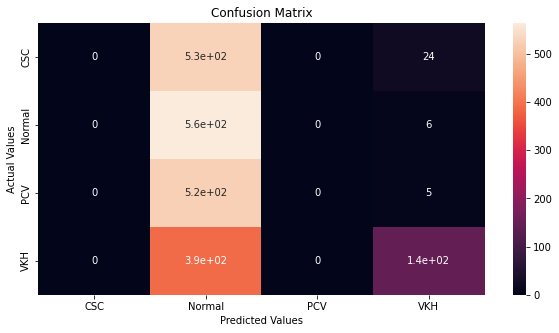

In [44]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

### หาค่า Accuracy,Recall, Precision, F1-score

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [46]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.324473


In [47]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.324473


In [48]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.269696


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [49]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.213282


### Grad cam

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import os
import matplotlib.cm as c_map

#### Configurable parameters

In [51]:
model_builder = keras.applications.xception.Xception
img_size = (256, 256)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "FQ8979 23-03-12 RE_000_cropped.png", "https://drive.google.com/drive/folders/1YIIdnJ2wjWMgGYU7RPtQHrHLJroKvh_c")

display(Image(img_path))

   8192/Unknown - 0s 0us/step

#### The Grad-CAM algorithm

In [52]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 256x256
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (256, 256, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 256, 256, 3)
    array = np.expand_dims(array, axis=0)
    return array


In [53]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [54]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="model21")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


UnidentifiedImageError: ignored

In [ ]:
plt.matshow(make_gradcam_heatmap(get_img_array, model, last_conv_layer_name))
plt.show()

#### Let's test-drive it

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

#### Create a superimposed visualization

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

#### Let's try another image

In [ ]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)